In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
sns.set()

In [11]:
advertising = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()
advertising.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [16]:
credit = pd.read_csv('data/Credit.csv', usecols = list(range(1,12)))
credit['Student2'] = credit['Student'].map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [17]:
auto = pd.read_csv('data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Least squares fit

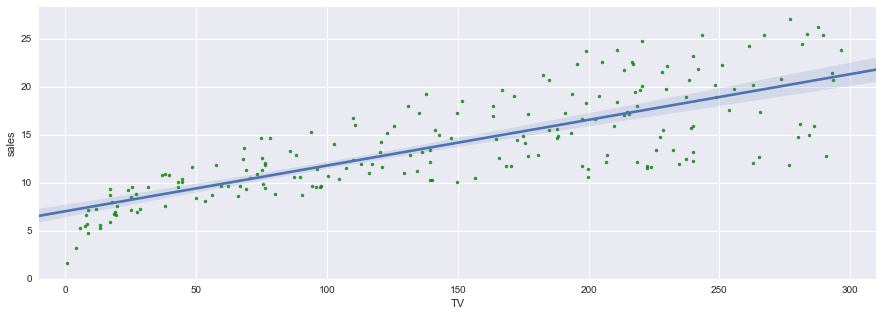

In [26]:
fig = plt.figure(figsize = (15,5))
sns.regplot(advertising['TV'], advertising['sales'], order=1, scatter_kws={'color':'g', 's':12})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Regression coefficients - RSS

In [72]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

# Reshape: -1 means "figure it out" and 1 will make each entry a row.
X = scale(advertising["TV"], with_mean=True, with_std=False).reshape(-1,1)
y = advertising["sales"]

regr.fit(X,y)
print("equation is Sales = {}*x+{}".format(regr.coef_[0],regr.intercept_))

equation is Sales = 0.04753664043301976*x+14.0225


In [35]:
sales_pred = regr.predict(X)
r2_score(y, sales_pred)

0.611875050850071

In [40]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_ -2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_ -0.02, regr.coef_ +0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size, B1.size))
# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    # ravel converts series to np array. We are calculating RSS for all 
    # columns inline in one go for each data point, and dividing by 1000
    Z[i,j] = ((y - (xx[i,j]+X.ravel() * yy[i,j]))**2).sum()/1000
#  Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2/1000)
min_rss

2.102530583131351

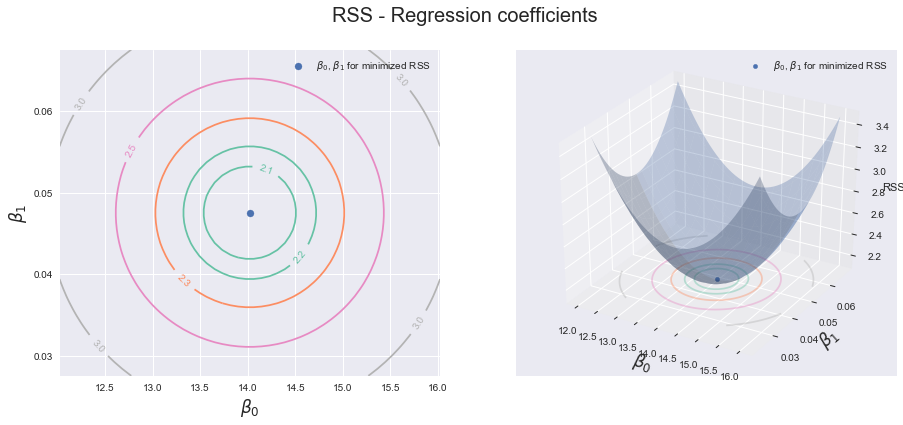

In [46]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)
# 121 -> 1 by 2, first position
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot 
CS = ax1.contour(xx,yy, Z, cmap=plt.cm.Set2, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot 
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx,yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set2, alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval 

Using Just TV

In [58]:
est = smf.ols('sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [59]:
# RSS with regression coefficients
((advertising["sales"] - (est.params[0] + est.params[1] * advertising["TV"]))**2).sum()/1000

2.1025305831313514

In [64]:
est = smf.ols('sales ~ TV + radio', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Fri, 06 Jul 2018   Prob (F-statistic):           4.83e-98
Time:                        19:09:55   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [78]:
regr = skl_lm.LinearRegression()

X = advertising[["radio", "TV"]].values
y = advertising["sales"]

regr.fit(X,y)
print(r"equation is Sales = {}*radio + {}*TV + {}".format(regr.coef_[0], regr.coef_[1], regr.intercept_))

equation is Sales = 0.18799422662030915*radio + 0.045754815101076145*TV + 2.9210999124051398


In [74]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['radio', 'TV']].describe()

,radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [79]:
# Create a coordinate grid
radio = np.arange(0,50)
TV = np.arange(0, 300)

B1, B2 = np.meshgrid(radio, TV, indexing='xy')
Z = np.zeros((TV.size, radio.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = (regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]* regr.coef_[1])

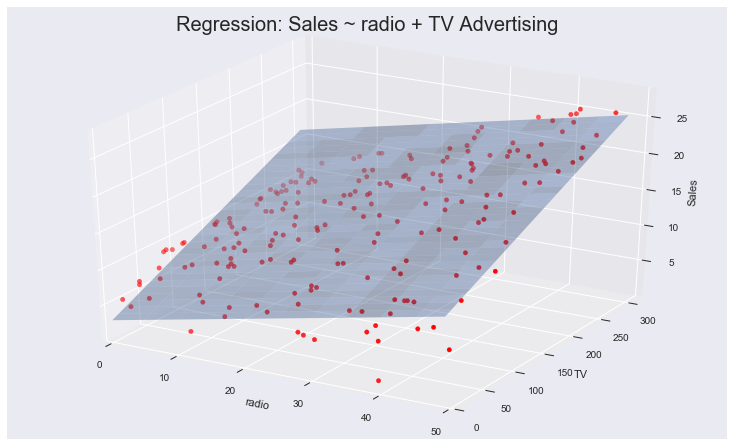

In [82]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising["radio"], advertising["TV"], advertising["sales"], c='r')

ax.set_xlabel('radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

### Other Considerations in the Regression Model

<Figure size 1600x960 with 0 Axes>

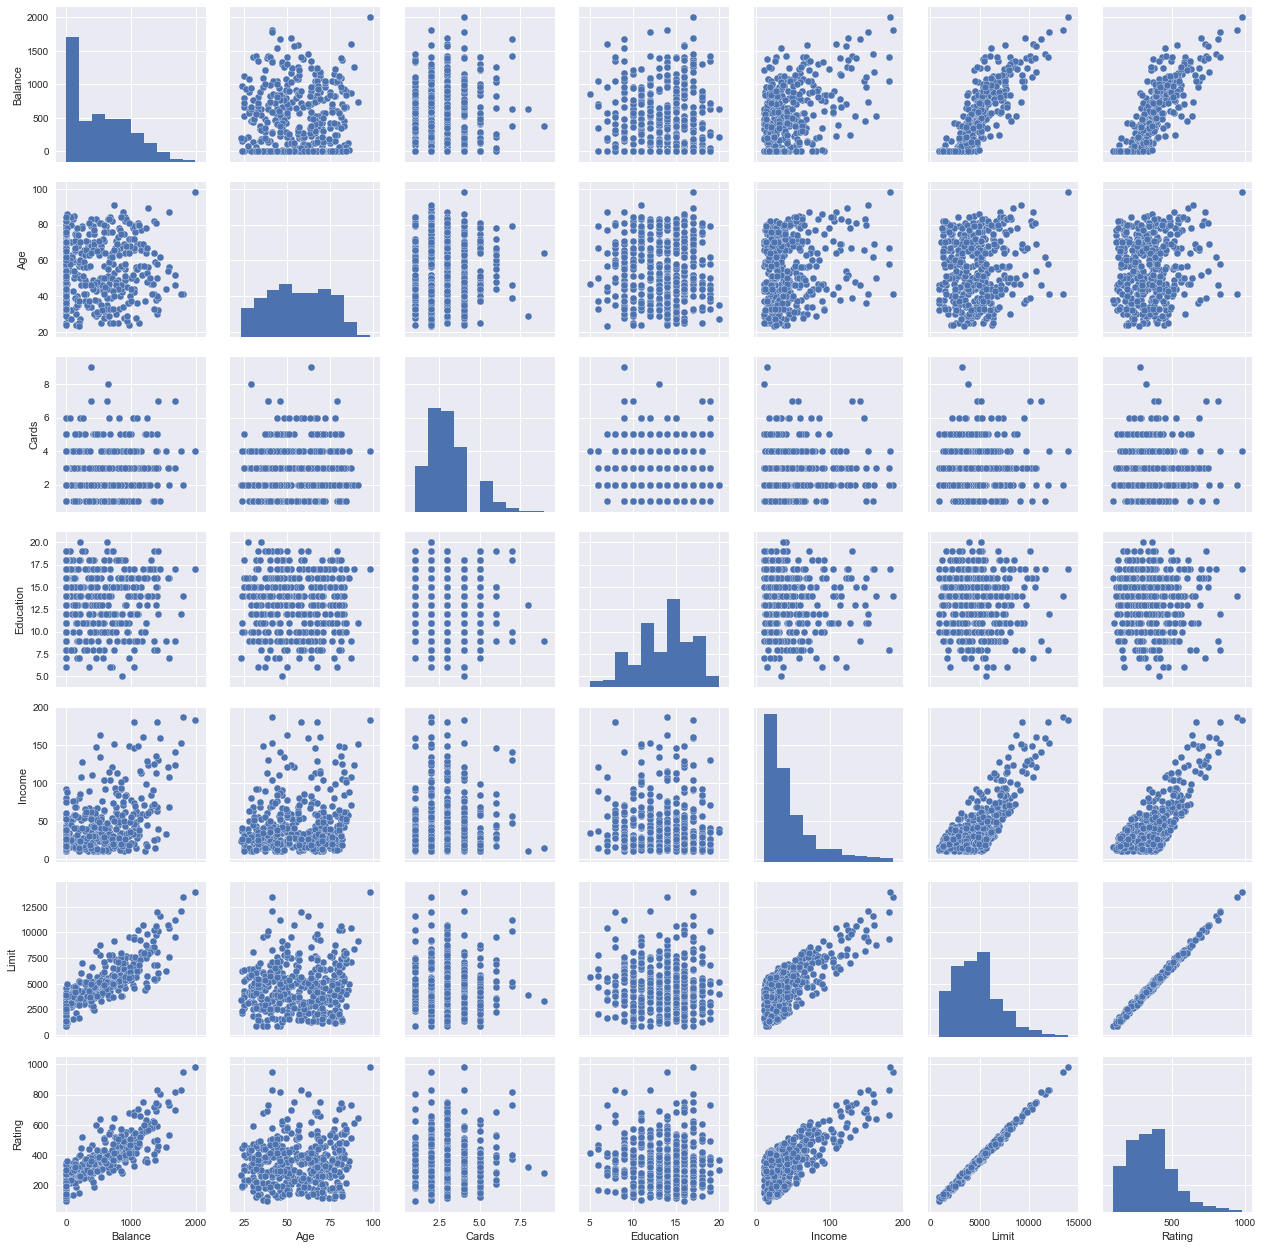

In [85]:
fig = plt.figure(figsize=(10,6), dpi= 160)
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

### interaction between qualitative and quantative variables

In [87]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


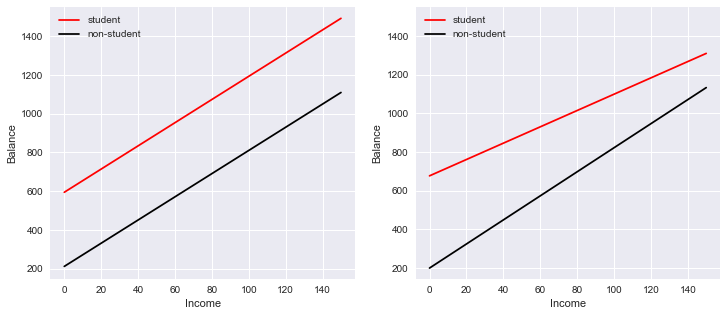

In [88]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

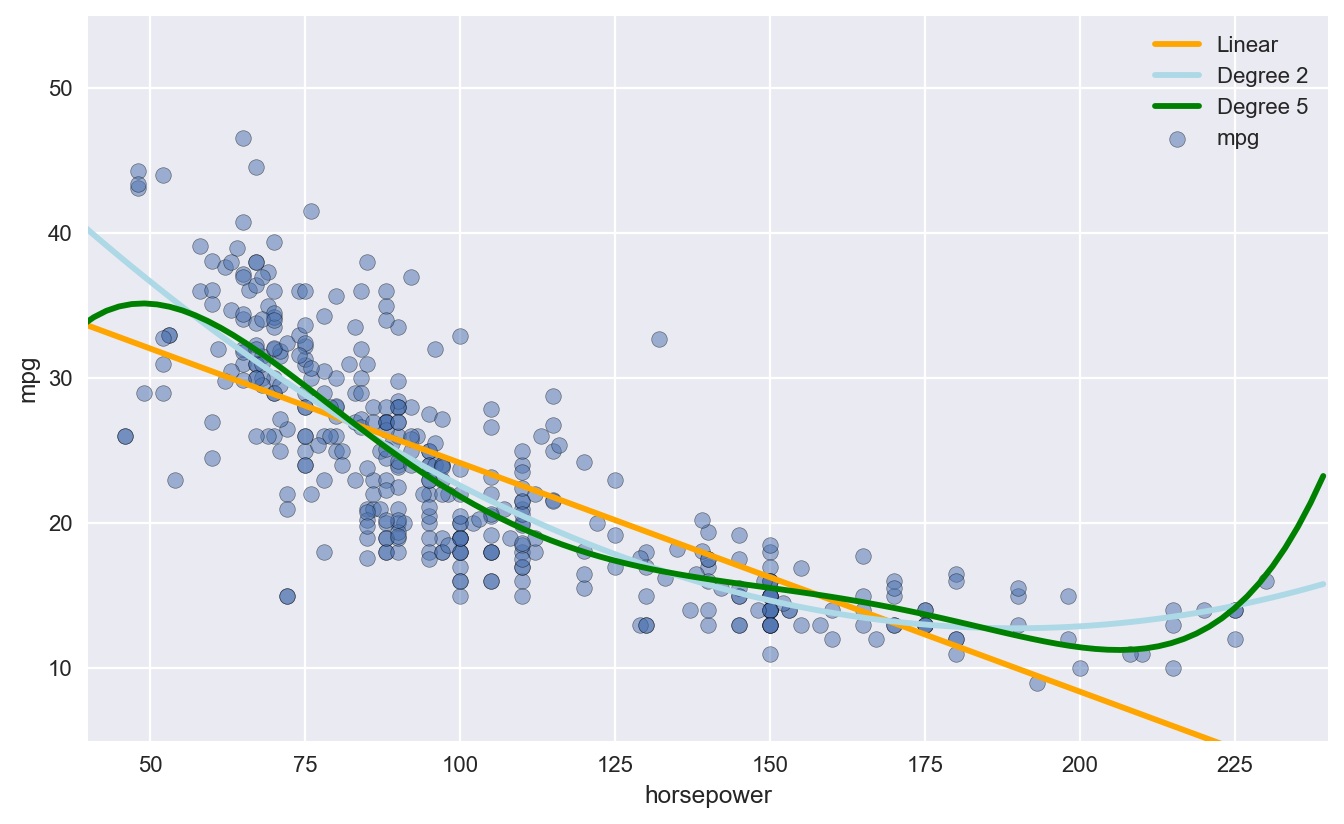

In [91]:
fig = plt.figure(figsize=(10,6), dpi= 160)
plt.scatter(auto['horsepower'], auto['mpg'], edgecolors='k', alpha=.5) 
sns.regplot(auto['horsepower'], auto['mpg'], ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto['horsepower'], auto['mpg'], ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto['horsepower'], auto['mpg'], ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

In [111]:
auto['horsepower2'] = auto['horsepower']**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,pred1,resid1,horsepower2,pred2,resid2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,19.416046,-1.416046,16900.0,17.091508,0.908492
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,13.891480,1.108520,27225.0,13.480156,1.519844
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,16.259151,1.740849,22500.0,14.658717,3.341283


In [101]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


In [110]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].values
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

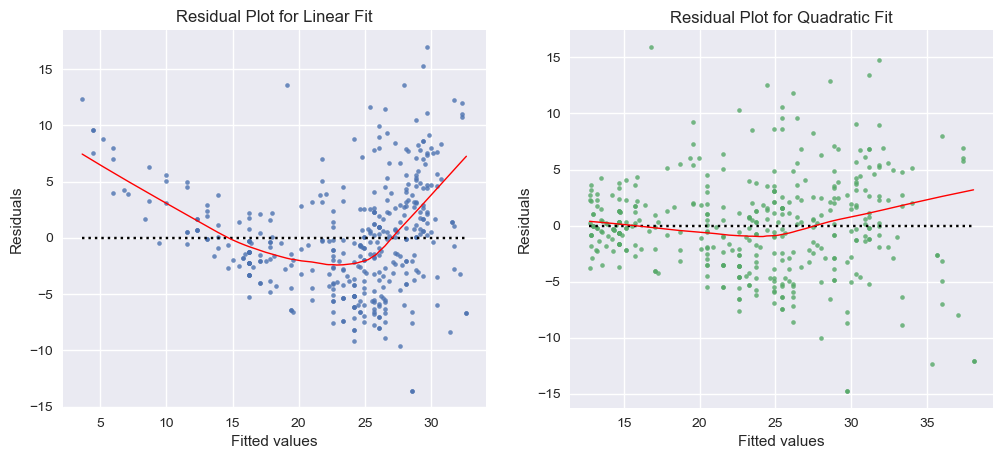

In [115]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), dpi=100)
sns.regplot(auto['pred1'], auto['resid1'], line_kws={'color':'r', 'lw':1}, scatter_kws={'s':11}, lowess=True, ax=ax1)
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

sns.regplot(auto['pred2'], auto['resid2'], line_kws={'color':'r', 'lw':1}, scatter_kws={'s':11}, lowess=True, ax=ax2)
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

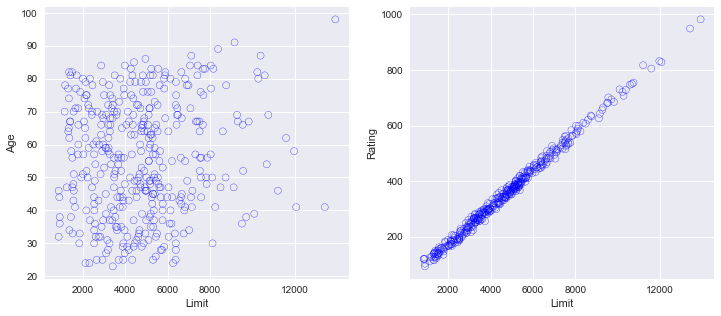

In [120]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit['Limit'], credit['Age'], facecolor='None', edgecolor='b')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit['Limit'], credit['Rating'], facecolor='None', edgecolor='b')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

This shows that while Limit and age don't seem to be correlated, rating and limit are certainly related